## Burn Cube C3 Sandbox (AWS) Notebook

### Calculating 4 years Geo Median

Let us use the odc-stats to generate Geo Median result ('2013-01-01','2016-12-31').

The CMDs are:

odc-stats save-tasks --frequency all --grid au-30 --temporal-range 2013--P3Y --gqa 1 --input-products ga_ls8c_ard_3
odc-stats run --config https://raw.githubusercontent.com/GeoscienceAustralia/dea-config/master/dev/services/odc-stats/geomedian/ga_ls8c_nbart_gm_cyear_3.yaml ga_ls8c_ard_3_2013--P3Y.db 1157:1158 --location file:///home/jovyan/Burn_Cube/burn_cube_geomad_test

Note: 

1. yes, we should use --temporal-range 2013--P3Y to get '2013-01-01','2016-12-31' range
2. the db index 1157:1158 refs to x45y19

In [ ]:
import itertools

import datacube
import dea_tools.datahandling
import dea_tools.bandindices
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import datetime
import seaborn as sns
import matplotlib.dates as mdates
import pandas as pd

import bc_utils as utils

dc = datacube.Datacube(app='Burn Cube C3 notebook')

## Use the extent from Geo MAD GeoTiff as Area of Interest

In [ ]:
import numpy as np
import geopandas as gpd
from shapely.geometry import Polygon
import rioxarray
import json
from PIL import Image
import xarray as xr
from dea_tools.spatial import xr_rasterize

from dea_tools.dask import create_local_dask_cluster

client = create_local_dask_cluster(return_client=True)

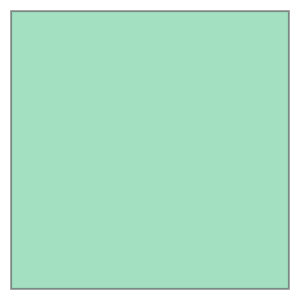

In [3]:
# https://explorer.dev.dea.ga.gov.au/products/ga_ls8c_nbart_gm_cyear_3/datasets/3ebab65f-6946-4e4c-8e5c-a56e132f63ed

# refs to: odc:region_code: x45y19

metadata = dc.index.datasets.get("3ebab65f-6946-4e4c-8e5c-a56e132f63ed")
geometry_list = [metadata.extent]
polygon = gpd.GeoDataFrame(index=range(len(geometry_list)), crs="epsg:3577", geometry=geometry_list)       
polygon.iloc[0].geometry

### Calculating 4 years Cosine distance and Euclidian distances

Still use ('2013-01-01','2016-12-31'), and calculating its cosine distance and euclidian distance.

Use Open Data Cube interface to load ARD dataset. Also use XArray to load Geo Median result from filesystem.


In [ ]:
def generate_subregion_result(dc, bands, period, mappingperiod, polgyon_geometry, x_i, y_i, split_count):
    
    gpgon = datacube.utils.geometry.Geometry(polgyon_geometry, crs="epsg:3577")
    
    ard = dea_tools.datahandling.load_ard(dc, products=['ga_ls8c_ard_3'], measurements=bands,
                                     geopolygon=gpgon,
                                     output_crs='EPSG:3577', resolution=(-30, 30), resampling={'fmask': 'nearest', '*': 'bilinear'},
                                     dask_chunks={'time': 1, 'x': int(3200/split_count), 'y': int(3200/split_count)},
                                     time=period, group_by='solar_day')
    
    x_code = "x45"
    y_code = "y19"
    region_code = f"{x_code}{y_code}"

    geomad_dataset = []

    for band_name in bands:
        band_data = rioxarray.open_rasterio(f"burn_cube_geomad_test/{x_code}/{y_code}/2013--P4Y/ga_ls8c_nbart_gm_cyear_3_{region_code}_2013--P4Y_final_{band_name}.tif")
        geomad_dataset.append(band_data[0, :, :].to_dataset(name=band_name))

    geomad_ds = xr.merge(geomad_dataset)

    geomed = geomad_ds[bands].to_array(dim='band').to_dataset(name='geomedian')
    geomed.attrs["crs"] = ard.crs
    
    ard = ard[bands].to_array(dim='band').to_dataset(name='ard')
    
    interval = int(len(ard.ard.x)/split_count)
    
    
    ard = ard.ard.isel(x=range(x_i*interval, (x_i + 1)*interval), y=range(y_i*interval, (y_i + 1)*interval))
    geomed = geomed.geomedian.isel(x=range(x_i*interval, (x_i + 1)*interval), y=range(y_i*interval, (y_i + 1)*interval))
    
    
    ard = ard.load()
    
    dis = utils.distances(ard, geomed)
    
    outliers_result = utils.outliers(ard, dis)
    
    del ard, dis
    
    mapping_ard = dea_tools.datahandling.load_ard(dc, products=['ga_ls8c_ard_3'], measurements=bands,
                                geopolygon=gpgon,
                                output_crs='EPSG:3577', resolution=(-30, 30), resampling={'fmask': 'nearest', '*': 'bilinear'},
                                dask_chunks={},
                                time=mappingperiod, group_by='solar_day')

    mapping_ard = mapping_ard[bands].to_array(dim='band').to_dataset(name='ard')
    mapping_ard = mapping_ard.ard.isel(x=range(x_i*interval, (x_i + 1)*interval), y=range(y_i*interval, (y_i + 1)*interval))
    mapping_ard = mapping_ard.load()
    
    mapping_dis = utils.distances(mapping_ard, geomed)
    
    return utils.severitymapping(mapping_dis, outliers_result, mappingperiod, method='NBR',growing=True)

In [ ]:
%%time

bands = [f'nbart_{band}' for band in ('red', 'green', 'blue', 'nir', 'swir_1', 'swir_2')]

period = ('2013-01-01','2016-12-31')
mappingperiod = ('2017-01-01','2017-12-31')


split_count = 2

out_list = []

for x_i in range(split_count):
    for y_i in range(split_count):
        out = generate_subregion_result(dc, bands, period, mappingperiod, polygon.geometry[0], x_i, y_i, split_count)
            
        if out:
            out_list.append(out)
            # save the output in netCDF
            comp = dict(zlib=True, complevel=5)
            encoding = {var: comp for var in out.data_vars} # compression
            # this will save it in the current working directory
            out.to_netcdf(f"BurnMapping_SirIvan_2017_C3_AWS_sandbox-x_{x_i}-y_{y_i}.nc",encoding=encoding)

        #    # save the output in GeoTIFF
        #    from datacube.utils.cog import write_cog

        #    for data_var_name in out.data_vars:
        #        write_cog(out[data_var_name], fname="BurnMapping_SirIvan_2017_C3_AWS_sandbox-" + data_var_name + f"-{i}.tif", overwrite=True)
    